In [1]:
import os, sklearn, pandas, numpy as np
from sklearn import svm
import skimage, skimage.io, skimage.filters
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
import keras
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Reshape, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model

Using TensorFlow backend.


In [3]:
# custom scripts
import config # params, constants
import data, models # functions that mutate outr data
from utils import utils, plot # custom functions, in local environment

 Dataset :: namedtuple(
    ['train' = ['img_name']
    , 'test' = ['img_name']
    , 'labels' = pandas.df('img_name','breed')
    , 'dict_index_to_label' = dict to convert label_index -> label_name
    , 'dict_label_to_index'= dict to convert label_name -> label_index
    


# Prepare dataset

In [4]:
import data # src/data.py
dataset = data.init_dataset()

In [5]:
# Read data
amt = 500 # amount of train, test data
x_train, y_train, amt1 = data.extract_all(dataset, dataset.train[0:amt])
x_test, y_test, amt2 = data.extract_all(dataset, dataset.train[amt:amt + amt])
amt = amt1
print(amt1,amt2)
data.show_info(x_train)

extract all data: 500
extract all data: 500
438 451
__ info: __
length:  438
type:  <class 'numpy.ndarray'>
shape:  (438, 250, 250, 3)


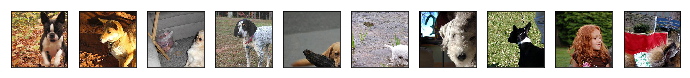

In [6]:
plot.multiple(x_train[:10])

### Prepare the labels

Encode the labels to one-hot vectors

In [7]:
# text-labels => int-labels
y_train = data.textlabels_to_numerical(dataset, y_train)
y_test = data.textlabels_to_numerical(dataset, y_test)
y_train[0:10]

[59, 75, 28, 39, 81, 57, 57, 4, 53, 119]

In [8]:
# int-labels => one-hot vectors
y_train = to_categorical(y_train)
# ? assuming y_test contains every possible class?
y_test = to_categorical(y_test)

print(y_train.shape, y_train[0].shape)
y_train[0]

(438, 120) (120,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

### Prepare images

In [9]:
# normalize data
# [0:255] => [0:1]
x_train = x_train / 255.
x_test = x_test / 255.

# Train a Sequential model (keras)

In [10]:
n_samples = x_train.shape[0] # = length of the list of images (matrices)
input_shape = x_train.shape[1:] # = shape of an individual image (matrix)
output_length = (y_train[0]).shape[0] # = length of an individual label
print('n samples:',n_samples)
print('shape:', input_shape)
print('output length:', output_length)

n samples: 438
shape: (250, 250, 3)
output length: 120


## Encoder

In [11]:
print(input_shape)
hidden_size = 8 # 2 # 8

input_ = Input(shape=input_shape)

x = Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=input_shape)(input_)
# 1/2
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(hidden_size)(x)

(250, 250, 3)


In [12]:
encoder = Model(input_, x)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 4)       112       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 8)       520       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 16)        2064      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
__________

## Decoder

In [13]:
# output_shape should be equal to input_shape
input_shape

(250, 250, 3)

In [14]:
encoded = Input(shape=(hidden_size,))

x = Dense(128)(encoded) # (None, 128)   
x = Reshape((4,4,8))(x) # (None, 4, 4, 8)  

x = UpSampling2D((8, 8))(x) # (None, 32, 32, 8)
x = Conv2D(4, (8, 8), activation='relu')(x) # (None, 25, 25, 4)
x = UpSampling2D((2, 2))(x) # (None, 100, 100, 4)
x = Conv2D(3, (1, 1), activation='relu')(x) # (None, 50, 50, 3) 

# go from 50x50 to input_shape[0:2] (=150x150)
a1 = round(input_shape[0] / 50)
a2 = round(input_shape[1] / 50)
param_a = (a1,a2) # (3,3)
print('param_a:',param_a)

x = UpSampling2D(param_a)(x) 

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoder = Model(encoded, decoded)

decoder.summary()

param_a: (5, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1152      
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)           0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 4)         2052      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 50, 50, 4)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 3)         15   

## Auto-encoder

In [15]:
auto = Model(input_, decoder(encoder(input_)))
auto.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 8)                 133776    
_________________________________________________________________
model_2 (Model)              (None, 250, 250, 3)       3303      
Total params: 137,079
Trainable params: 137,079
Non-trainable params: 0
_________________________________________________________________


### Loss function
Train with binary cross-entropy (each pixel is seen as a probability).

Training data (pixel values) must be normalized to [0:1]

In [16]:
auto.compile(optimizer='adam', loss='binary_crossentropy')

## Train model

In [17]:
# Compute a batch size
batch_size = 128
# n epochs = n iterations over all the training data
epochs = 9

In [18]:
x_train.shape

(438, 250, 250, 3)

In [19]:
# no validation is needed for the autoencoder, as the goal is to reconstruct the data as good as possible
auto.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

Epoch 1/9
438/438 [==============================] - 28s 63ms/step - loss: 0.6917
Epoch 2/9
438/438 [==============================] - 22s 49ms/step - loss: 0.6891
Epoch 3/9
438/438 [==============================] - 22s 51ms/step - loss: 0.6876
Epoch 4/9
438/438 [==============================] - 21s 49ms/step - loss: 0.6864
Epoch 5/9
438/438 [==============================] - 21s 48ms/step - loss: 0.6851
Epoch 6/9
438/438 [==============================] - 21s 47ms/step - loss: 0.6822
Epoch 7/9
438/438 [==============================] - 20s 47ms/step - loss: 0.6779
Epoch 8/9
438/438 [==============================] - 20s 47ms/step - loss: 0.6708
Epoch 9/9
438/438 [==============================] - 21s 47ms/step - loss: 0.6622


## Generate new images

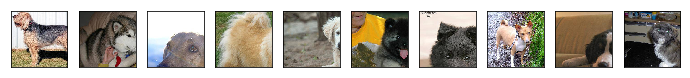

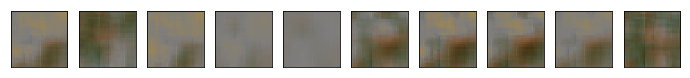

In [20]:
inputs = x_test[:10, :, :, :]
outputs = auto.predict(inputs)

plot.multiple(inputs[:10])
plot.multiple(outputs[:10])